### Automating protest categories (MSA 2020) 
Using machine learning to predict protester demands based on protest descriptions. 

In light of recent civil unrest, including #blacklivesmatter and #metoo movements,it has never been more important for people in positions of power to listen voices.

<p> For my microsoft student accelerator project, I will be trying to develop machine learning model which can read descriptions about government protests, and construct a suitable label for the event.

<p> Along with certain RSS scraping methods, I would like to extend this project to automatically label incoming news articles in accordance to protest demands. I would also love to have more comprehesive labels to describe each event, to provide insightful analysis of what specifically demands are around the world, to see if there are any similarities and differences. 

### Packages required

In [117]:
#import used packages
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import keras_metrics
from keras.regularizers import l2
from nltk.corpus import stopwords



### The Dataset

I will be using a dataset collected by the Mass Mobilisation data project. The dataset consists of protest events with over 50 or more protesters,  that cover 162 countries between 1990 and 2018. Each event has been extensively characterised based on country, date, protester demands and state responses. Information about these events has mostly been taken from news source. Each event also consists of a 200 word short description of the event that took place. The focus of this project will be based on trying to automatically label these descriptions based on protester demands. You can gain further details about the demands using the following link. 

The protest demands were categorised into 8 categories, as inspected in the following code. 

* political behavior, process
* land farm issue'police brutality
* labor wage dispute
* price increases, tax policy
* social restrictions 
* removal of politicans
* other or ''

In [118]:
#move strata dataset from the project into a pandas dataframes
og_dataset = pd.read_stata("mmALL_020619_v15.dta")


#show all columns in dataset 
print("All columns within the dataset")
print(og_dataset.columns.values)

#shows all unique values in the protesterdemand column of the main dataset
print("Unique protester demands: ")
print(og_dataset.protesterdemand1.unique())



All columns within the dataset
['id' 'country' 'ccode' 'year' 'region' 'protest' 'protestnumber'
 'startday' 'startmonth' 'startyear' 'endday' 'endmonth' 'endyear'
 'protesterviolence' 'location' 'participants_category' 'participants'
 'protesteridentity' 'protesterdemand1' 'protesterdemand2'
 'protesterdemand3' 'protesterdemand4' 'stateresponse1' 'stateresponse2'
 'stateresponse3' 'stateresponse4' 'stateresponse5' 'stateresponse6'
 'stateresponse7' 'sources' 'notes']
Unique protester demands: 
['political behavior, process' 'land farm issue' 'police brutality'
 'labor wage dispute' 'price increases, tax policy' ''
 'social restrictions' 'removal of politician']


Even though there are more than one protester demand catergory for some events, after an intial inspection, out of the 15,000 events in the data set at bit more than 2000 had more than one protester demand. Therefore I omitted them from the dataset. I also simplified the dataframe so that it only had to columns, the protester demand label and the description or notes in the dataset, to get the data ready for data processing. 

In [119]:
#rm samples from dataset which has more than one protester demand 
og_dataset = og_dataset[og_dataset.protesterdemand2 == ""]
#rm all columns except protesters and the description of the mass mobilisation event 
simp_dataset = og_dataset.loc[:, og_dataset.columns.intersection(['protesterdemand1','notes'])]
print("Columns left")
simp_dataset.head()

Columns left


,protesterdemand1,notes
1,"political behavior, process",protestors were only identified as young peop...
2,"political behavior, process","THE Queen, after calling on Canadians to rema..."
3,land farm issue,Canada s federal government has agreed to acq...
4,"political behavior, process",Protests were directed against the state due t...
5,police brutality,Canadian army troops today fired tear gas int...


Generally speaking I did not think the descriptions composed of many meaningless of useless words, aside from stop words. Therefore, the only thing I decided to do was remove the stop words in my description, and change all capitalised words into non-capitalised words. This was done with the following function. 

I then wanted to split my data into test, validation and training sets. 

Next, I cleaned the text for frequent useless words like "I" , "she" which doesn't add any meaning to the data.

In [126]:
# clean text to remove useless words with no added meaning (stop words)
# non-capitalise words 

simp_dataset.notes = simp_dataset.notes.reset_index(drop=True)

def clean_text(text):
    if type(text) == float:
        return text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    text = text.lower()
    return text

simp_dataset.notes = simp_dataset.notes.apply(clean_text)

In [127]:
og_dataset = og_dataset[og_dataset.protesterdemand2 == ""]
simp_dataset = og_dataset.loc[:, og_dataset.columns.intersection(['protesterdemand1','notes'])]
simp_dataset.head()
non_test = simp_dataset.iloc[ :12000,:]
test = simp_dataset.iloc[12000:,:]
print(non_test.shape)
print(test.shape)

(12000, 2)
(1180, 2)


 After that, I tokenised and paded each protest description using keras's tokeniser and padding functions. 

In [128]:
"""Took training data and tokenised each protest description 
   with Kera's tokeniser tool """
train_clean = [review for review in non_test.notes]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean)
train_seq = tokenizer.texts_to_sequences(train_clean)
word_index = tokenizer.word_index
print(train_seq[1])



[1, 1940, 33, 219, 7, 7971, 3, 1370, 415, 2744, 27, 5, 1284, 416, 1205, 4574, 45, 3, 845, 3445, 2463, 8, 88, 2169, 702, 6, 672, 449, 608, 57, 12601, 34, 989, 354, 44, 3, 663, 1, 1940, 12602, 166, 6, 500, 4, 12603, 4574, 10, 693, 29, 424, 2464, 11, 8961, 12604, 1, 990, 193, 96, 5, 1877, 2964, 1254, 9, 35, 239, 1116, 12601, 2745, 1, 958, 62, 91, 2, 1, 16960, 4357, 2307, 13, 113, 30, 7972, 1, 505, 16, 6, 7211, 797, 162, 6, 229, 15, 99, 1, 2170, 1, 1940, 8, 3041, 156, 2, 6, 1054, 2414, 1140, 2463, 64, 19, 428, 7973, 11, 35, 239, 112, 2, 1, 1478, 16961, 16962, 57, 2, 74, 6603, 4, 1, 16963, 437, 16964, 1070, 915, 26, 162, 6, 5103, 36, 4791, 61, 85, 1, 6125, 16965, 500, 4, 12603, 6, 51, 2, 2598, 31, 2015, 327, 157, 1, 5393, 1717, 22, 1, 50, 2, 5393]


In [129]:
"""find the length of views by inspecting the length of view at the
80th , 85th, 90th and 95th percentile"""
#create a new dataframe containing lengths of each protest description
lengths = pd.DataFrame(map(len,train_seq), columns=['counts'])
"""determine the length at the 80th, 85th, 90th and 95th percentile
to figure out the average length of each protest de"""
lengths.counts.describe()
print("The average length of each piece at different percentiles")
print(np.percentile(lengths.counts, 80))
print(np.percentile(lengths.counts, 85))
print(np.percentile(lengths.counts, 90))
print(np.percentile(lengths.counts, 95))
#based on the longest average review length, pad sequences. 
max_review_length = 202
train_pad = pad_sequences(train_seq, maxlen = max_review_length)

The average length of each piece at different percentiles
111.0
128.0
155.0
202.0


I then turned first protesterdemand labels into vectorised labels. 

In [130]:
Y = pd.get_dummies(non_test['protesterdemand1']).values
print(Y)


print('Shape of label tensor:', Y.shape)
x_train, x_valid, y_train, y_valid = train_test_split(train_pad,Y, test_size = 0.15, random_state = 2)
print(x_train.shape)
print(x_valid.shape)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
Shape of label tensor: (12000, 8)
(10200, 202)
(1800, 202)


I then started to train my model with the following parameters: 

In [179]:
model = Sequential()
model.add(Embedding(30000, 100, input_length=train_pad.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='softmax'))       
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
          
epochs = 2
batch_size = 64

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/michellewong/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10200 samples, validate on 1800 samples
Epoch 1/4
10200/10200 [==============================] - 144s 14ms/step - loss: 1.2554 - accuracy: 0.6941 - val_loss: 1.1701 - val_accuracy: 0.6950
Epoch 2/4
10200/10200 [==============================] - 142s 14ms/step - loss: 1.0384 - accuracy: 0.7212 - val_loss: 1.0947 - val_accuracy: 0.7044
Epoch 3/4
10200/10200 [==============================] - 150s 15ms/step - loss: 0.8812 - accuracy: 0.7504 - val_loss: 1.0835 - val_accuracy: 0.7206
Epoch 4/4
10200/10200 [==============================] - 148s 14ms/step - loss: 0.7315 - accuracy: 0.7884 - val_loss: 1.0394 - val_accuracy: 0.7111


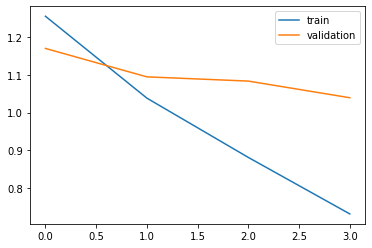

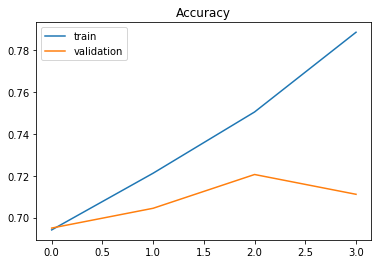

In [180]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

In [181]:
test_clean = []
for review in test.notes:
    test_clean.append(review)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_clean)
test_seq = tokenizer.texts_to_sequences(test_clean)
word_index = tokenizer.word_index
lengths = []
for review in test_seq:
    lengths.append(len(review))
lengths = pd.DataFrame(lengths, columns=['counts'])
lengths.counts.describe()
max_review_length = 202
test_pad = pad_sequences(train_seq, maxlen = max_review_length)
Y = pd.get_dummies(non_test['protesterdemand1']).values


index_of_label = []
labels = pd.get_dummies(og_dataset.protesterdemand1.unique()).values
for i in labels:
    index_of_label.append(np.argmax(i))

print(index_of_label)

test_number = 10
pred = model.predict(test_pad[[test_number]])

#test with specific examples 
labels = ['political behavior, process','land farm issue','police brutality',
 'labor wage dispute','price increases, tax policy','',
 'social restrictions','removal of politician']
print(np.argmax(pred))
print("predicted label: ",labels[index_of_label.index(int(np.argmax(pred)))])
print("actual label: ",test.iloc[test_number, 0])


#test based on whole dataset accuracy 

scores = model.evaluate(test_pad, Y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


[4, 2, 3, 1, 5, 0, 7, 6]
4
predicted label:  political behavior, process
actual label:  political behavior, process
Accuracy: 78.79%


The model doesn't seem to be very accurate and tended to overfit the data after epoch 2, even when regularisation and drop out parameters has been implemented. This is likely because some of the protest data had very short descriptions and descriptions weren't very detailed. Perhaps a way to improve the model could be use the articles which the events were based, however some were too old to have the correct descriptions. 